In [2]:
# Import Libraries
# Imports
import os, warnings, cv2
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
import pandas as pd

from os import listdir
from os.path import isfile, join
from shutil import rmtree

from tensorflow import keras
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification

# 1| Data Understanding
### 1.1| Load the directory 
main_path = '/kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K'

sub_dir =os.listdir(main_path)

### 1.2| Create The DataFrame
Data_df=pd.DataFrame({'ID': [], 'Class':[]})

for subdir in sub_dir:
    mypath = join(main_path,subdir)
    files=[f for f in listdir(mypath)]
    classes=[subdir for c in files]
    files_df = pd.DataFrame({'ID':files, 'Class':classes})
    Data_df = Data_df.append(files_df)

Data_df

,ID,Class
0,MUC-GQLYEALK.tif,MUC
1,MUC-FYTGWFGD.tif,MUC
2,MUC-AVNDTFWS.tif,MUC
3,MUC-DQPFGFLS.tif,MUC
4,MUC-FNEDYLHG.tif,MUC
...,...,...
10441,STR-NQFCFNPH.tif,STR
10442,STR-KPWLGGCI.tif,STR
10443,STR-FFCLCFPE.tif,STR
10444,STR-HGPELQKY.tif,STR


the distribution of classes:
NORM     8763
MUC      8896
ADI     10407
STR     10446
BACK    10566
DEB     11512
LYM     11557
MUS     13536
TUM     14317
Name: Class, dtype: int64


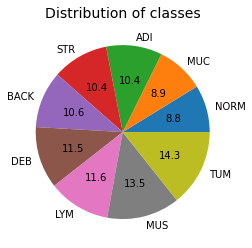

In [4]:
### 1.3| Data Visualization
# The problem can be better understood by visualizing the distribution of the data. In most cases, an imbalanced dataset cannot produce a quality model. However, in this case, the distribution does not seem to be a source of concern as shown below. Furthermore, examining the patches within our data indicates that patches from different classes are easily distinguishable, suggesting that there should be no major issues in this regard.
# Distribution of the Classes
class_of_patch = Data_df.Class.value_counts()
print('the distribution of classes:\n{}'.format(class_of_patch[::-1]))
class_of_patch_labels = ['NORM','MUC','ADI','STR','BACK','DEB','LYM','MUS','TUM']
class_of_patch_values = class_of_patch[::-1]

plt.pie(class_of_patch_values, labels=class_of_patch_labels, startangle=0, autopct='%1.1f')
plt.title('Distribution of classes', fontsize=14)
plt.show()

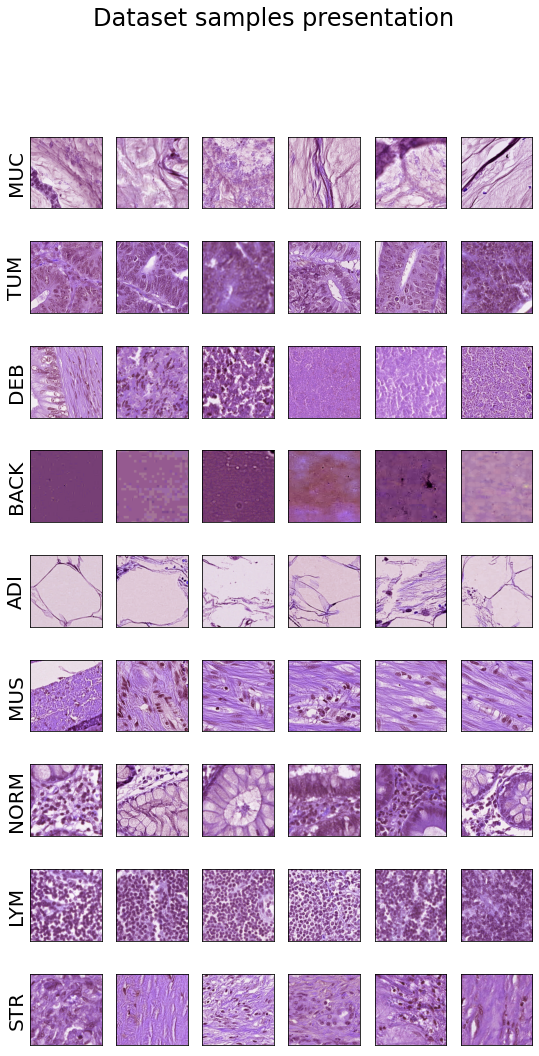

In [5]:
fig, axs = plt.subplots(9, 6, figsize=(9, 17))
fig.suptitle('Dataset samples presentation', size=24)

for i, cls in enumerate(sub_dir):
    samples = Data_df[Data_df['Class'] == cls].sample(6)
    for j, img_path in enumerate(samples['ID']):
        img = cv2.imread(join(main_path, cls, img_path))
        axs[i, j].imshow(img)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
    axs[i, 0].set_ylabel(cls, size=20)
    

Class Distribution of Training Examples:
TUM     10021
MUS      9475
LYM      8090
DEB      8058
BACK     7396
STR      7312
ADI      7285
MUC      6228
NORM     6134
Name: Class, dtype: int64 

Class Distribution of Validation Examples:
TUM     2148
MUS     2031
LYM     1733
DEB     1727
BACK    1585
STR     1567
ADI     1561
MUC     1334
NORM    1315
Name: Class, dtype: int64 

Class Distribution of Test Examples:
TUM     2148
MUS     2030
LYM     1734
DEB     1727
BACK    1585
STR     1567
ADI     1561
MUC     1334
NORM    1314
Name: Class, dtype: int64 



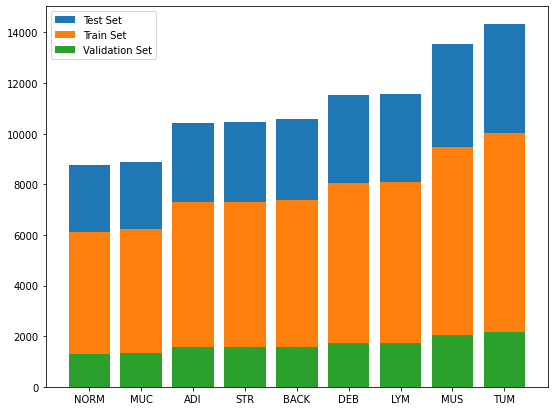

In [7]:
### 1.4| Spliting The Data to Training and Validation Sets
# On the basis of our dataframe, now we can split our dataset for the use of training, validation and testing. Further, we can plot quantities of each set to check for any imbalance between same classes of each set. Altough it is not necessary, because this issue is considered in the used module from sklearn library.
# Split into train and test
train_df, test_df = train_test_split(Data_df, test_size=0.15, random_state=42, shuffle=True, stratify=Data_df['Class'])

# Split train set into train and validation
train_df, val_df = train_test_split(train_df, test_size=0.176471, random_state=42, shuffle=True, stratify=train_df['Class'])
# Check the distribution of data in training and validation sets
train_val_test_data = [train_df, val_df, test_df]
data_names = ['Training', 'Validation', 'Test']

for i, data in enumerate(train_val_test_data):
    class_of_data_patch = data.Class.value_counts()
    print('Class Distribution of {} Examples:\n{}'.format(data_names[i], class_of_data_patch), '\n')
    
# Bar plot for checking the distribution
class_of_train_patch = train_df.Class.value_counts()
class_of_val_patch = val_df.Class.value_counts()
class_of_test_patch = test_df.Class.value_counts()

bar_fig, bar_axis = plt.subplots(figsize=(9,7))

sub_dir_list =  ['NORM', 'MUC', 'ADI', 'STR', 'BACK', 'DEB', 'LYM', 'MUS', 'TUM']

bar_axis.bar(sub_dir_list, class_of_patch[::-1], label='Test Set')
bar_axis.bar(sub_dir_list, class_of_train_patch[::-1], label='Train Set')
bar_axis.bar(sub_dir_list, class_of_val_patch[::-1], label='Validation Set')

bar_axis.legend()

In [8]:
### 1.4.1| Creating Folders for the Splited Data
# For Convinience. it is better to write the splitted sets of data to seperated directories. In that way,we could simply call them from the directory into our generator.
# # remove the SplittedData folder
# import shutil

# # dir_path = '/kaggle/working/SplittedData'

# shutil.rmtree(dir_path)
main_dir = '/kaggle/working/SplittedData'

os.makedirs(main_dir, exist_ok=True)

train_dir = os.path.join(main_dir, 'Training')
os.makedirs(train_dir, exist_ok=True)

val_dir = os.path.join(main_dir, 'Validation')
os.makedirs(val_dir, exist_ok=True)

test_dir = os.path.join(main_dir, 'Test')
os.makedirs(test_dir, exist_ok=True)

for cls in sub_dir:
    train_sub_dir = os.path.join(train_dir, cls)
    os.makedirs(train_sub_dir, exist_ok=True)

    val_sub_dir = os.path.join(val_dir, cls)
    os.makedirs(val_sub_dir, exist_ok=True)

    test_sub_dir = os.path.join(test_dir, cls)
    os.makedirs(test_sub_dir, exist_ok=True)

### 1.4.2| Writing the splitted data in folders
from tqdm import tqdm
import shutil

Data_df.set_index('ID', inplace=True)

for img, label in tqdm(zip(train_df['ID'], train_df['Class']), desc='Copying train images'):
    source = join(main_path, label, img)
    dest = join(train_dir, label)
    shutil.copy(source, dest)

for img, label in tqdm(zip(val_df['ID'], val_df['Class']), desc='Copying validation images'):
    source = join(main_path, label, img)
    dest = join(val_dir, label)
    shutil.copy(source, dest)

for img, label in tqdm(zip(test_df['ID'], test_df['Class']), desc='Copying test images'):
    source = join(main_path, label, img)
    dest = join(test_dir, label)
    shutil.copy(source, dest)

Copying train images: 69999it [06:35, 176.81it/s]
Copying validation images: 15001it [01:33, 159.77it/s]
Copying test images: 15000it [01:28, 169.68it/s]


# Vision Transformers

This notebook trains a  Vision Transformer on the Butterfly dataset.

Code for the following video:
https://youtu.be/0tjuRnkFHKg

In [143]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# We use a butterfly dataset of 50 species to demonstrate the classification method

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [144]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [145]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [146]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [147]:
import matplotlib.pyplot as plt
%matplotlib inline

In [148]:
import sys
from tqdm import tqdm
import time
import copy

In [149]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [150]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        # data augmentation
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "Training/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "Validation/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "Test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [151]:
dataset_path = "/kaggle/working/SplittedData/"

In [152]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [153]:
classes = get_classes("/kaggle/working/SplittedData/Training/")
print(classes, len(classes))

['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'] 9


In [154]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [155]:
print(len(train_loader), len(val_loader), len(test_loader))

547 469 469


In [156]:
print(train_data_len, valid_data_len, test_data_len)

69999 15001 15000


In [157]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [158]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


In [159]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=192, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=512, out_features=9, bias=True)
)


In [160]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

In [161]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

Epoch 0/9
----------


100%|██████████| 547/547 [04:38<00:00,  1.97it/s]


train Loss: 0.7596 Acc: 0.9029


100%|██████████| 469/469 [00:54<00:00,  8.60it/s]


val Loss: 0.6738 Acc: 0.9357

Epoch 1/9
----------


100%|██████████| 547/547 [04:38<00:00,  1.97it/s]


train Loss: 0.6742 Acc: 0.9417


100%|██████████| 469/469 [00:52<00:00,  8.92it/s]


val Loss: 0.6341 Acc: 0.9570

Epoch 2/9
----------


100%|██████████| 547/547 [04:24<00:00,  2.07it/s]


train Loss: 0.6556 Acc: 0.9493


100%|██████████| 469/469 [00:51<00:00,  9.18it/s]


val Loss: 0.6285 Acc: 0.9552

Epoch 3/9
----------


100%|██████████| 547/547 [04:21<00:00,  2.09it/s]


train Loss: 0.6458 Acc: 0.9545


100%|██████████| 469/469 [00:50<00:00,  9.37it/s]


val Loss: 0.6127 Acc: 0.9633

Epoch 4/9
----------


100%|██████████| 547/547 [04:22<00:00,  2.08it/s]


train Loss: 0.6384 Acc: 0.9581


100%|██████████| 469/469 [00:51<00:00,  9.12it/s]


val Loss: 0.6089 Acc: 0.9635

Epoch 5/9
----------


100%|██████████| 547/547 [04:21<00:00,  2.09it/s]


train Loss: 0.6334 Acc: 0.9600


100%|██████████| 469/469 [00:52<00:00,  8.86it/s]


val Loss: 0.6086 Acc: 0.9650

Epoch 6/9
----------


100%|██████████| 547/547 [04:21<00:00,  2.09it/s]


train Loss: 0.6297 Acc: 0.9612


100%|██████████| 469/469 [00:52<00:00,  8.93it/s]


val Loss: 0.6014 Acc: 0.9677

Epoch 7/9
----------


100%|██████████| 547/547 [04:22<00:00,  2.08it/s]


train Loss: 0.6263 Acc: 0.9625


100%|██████████| 469/469 [00:51<00:00,  9.16it/s]


val Loss: 0.5979 Acc: 0.9695

Epoch 8/9
----------


100%|██████████| 547/547 [04:25<00:00,  2.06it/s]


train Loss: 0.6239 Acc: 0.9637


100%|██████████| 469/469 [00:50<00:00,  9.30it/s]


val Loss: 0.6011 Acc: 0.9687

Epoch 9/9
----------


100%|██████████| 547/547 [04:24<00:00,  2.07it/s]


train Loss: 0.6205 Acc: 0.9653


100%|██████████| 469/469 [00:52<00:00,  8.99it/s]


val Loss: 0.5929 Acc: 0.9706

Training complete in 53m 0s
Best Val Acc: 0.9706


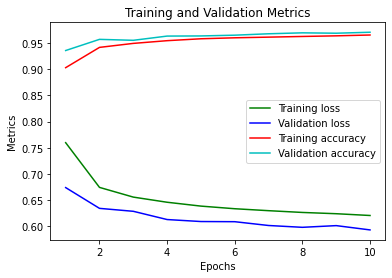

In [162]:
import matplotlib.pyplot as plt

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
#     train_loss_list = []
#     val_loss_list = []
#     train_acc_list = []
#     val_acc_list = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            else:
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    # plot loss and accuracy curves
    epochs = range(1, num_epochs+1)
    plt.plot(epochs, train_loss_list, 'g', label='Training loss')
    plt.plot(epochs, val_loss_list, 'b', label='Validation loss')
    plt.plot(epochs, train_acc_list, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc_list, 'c', label='Validation accuracy')
    plt.title('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()
    
    return model

model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler)


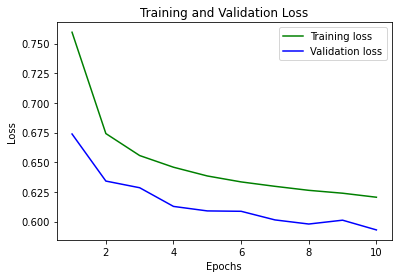

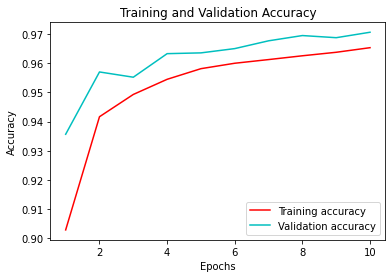

In [163]:
# plot training and validation loss
epochs = range(1, 11)
plt.plot(epochs, train_loss_list, 'g', label='Training loss')
plt.plot(epochs, val_loss_list, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.plot(epochs, train_acc_list, 'r', label='Training accuracy')
plt.plot(epochs, val_acc_list, 'c', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Testing on our Testset

In [164]:
from sklearn.metrics import confusion_matrix
import itertools

test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
y_true = []
y_pred = []
model_ft.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            y_true.append(label.item())
            y_pred.append(pred[i].item())
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))


100%|██████████| 469/469 [00:56<00:00,  8.33it/s]

Test Loss: 0.0009
Test Accuracy of   ADI: 99% (1545/1559)
Test Accuracy of  BACK: 100% (1585/1585)
Test Accuracy of   DEB: 95% (1655/1727)
Test Accuracy of   LYM: 98% (1708/1729)
Test Accuracy of   MUC: 96% (1282/1329)
Test Accuracy of   MUS: 95% (1939/2029)
Test Accuracy of  NORM: 95% (1245/1308)
Test Accuracy of   STR: 95% (1500/1564)
Test Accuracy of   TUM: 96% (2070/2146)
Test Accuracy of 97% (14529/14976)


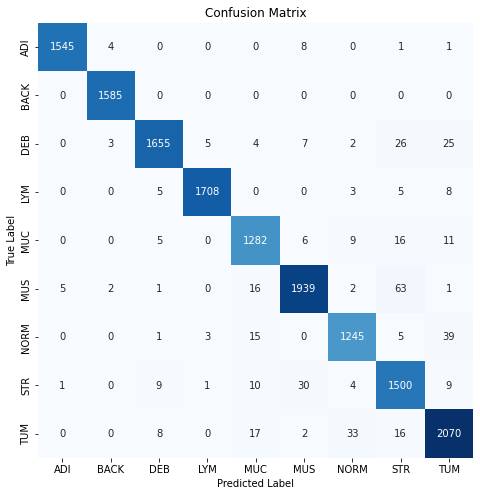

In [165]:

import seaborn as sns

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

labels = ['ADI','BACK', 'DEB','LYM','MUC','MUS','NORM','STR','TUM']
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot= True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=labels, yticklabels= labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



# Test with Extrenal Dataset CRC-VAL-HE-7K

In [166]:
from sklearn.metrics import confusion_matrix
import itertools

test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
y_true = []
y_pred = []
model_ft.eval()

# ===================================================================================
transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
test_data = datasets.ImageFolder(os.path.join("/kaggle/input/crc-val-he-7k/", "CRC-VAL-HE-7K"), transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=4)
# ===================================================================================

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            y_true.append(label.item())
            y_pred.append(pred[i].item())
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))


100%|██████████| 225/225 [00:27<00:00,  8.09it/s]

Test Loss: 0.0005
Test Accuracy of   ADI: 94% (1261/1334)
Test Accuracy of  BACK: 99% (844/847)
Test Accuracy of   DEB: 93% (318/339)
Test Accuracy of   LYM: 92% (587/633)
Test Accuracy of   MUC: 94% (976/1034)
Test Accuracy of   MUS: 84% (501/592)
Test Accuracy of  NORM: 94% (697/739)
Test Accuracy of   STR: 59% (251/420)
Test Accuracy of   TUM: 89% (1097/1230)
Test Accuracy of 91% (6532/7168)


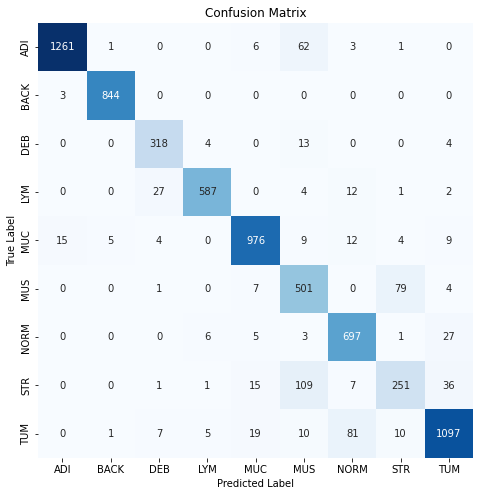

In [167]:

import seaborn as sns

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

labels = ['ADI','BACK', 'DEB','LYM','MUC','MUS','NORM','STR','TUM']
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot= True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=labels, yticklabels= labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



# Save the model

In [168]:
# our model earns 93% test accuracy, which is very high. lets save it
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.cpu(), example)
traced_script_module.save("model_vision.pt")